# 时间序列

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from dateutil.parser import parse

## Peaks


In [2]:
passengers = pl.read_csv("data/air_passengers.csv").with_row_index()
passengers.head()

index,date,value
u32,str,i64
0,"""1949-01-01""",112
1,"""1949-02-01""",118
2,"""1949-03-01""",132
3,"""1949-04-01""",129
4,"""1949-05-01""",121


In [3]:
traffic = passengers["value"]
doubled_iff = np.diff(np.sign(np.diff(traffic)))
peak_locations = np.where(doubled_iff == -2)[0] + 1

doubled_iff2 = np.diff(np.sign(np.diff(-1 * traffic)))
trough_locations = np.where(doubled_iff2 == -2)[0] + 1

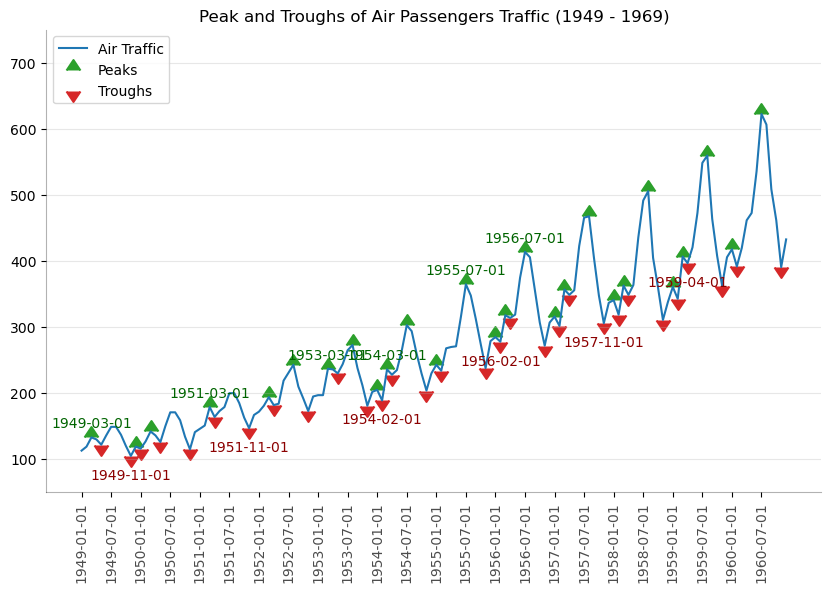

In [4]:
_, ax = plt.subplots(figsize=(10, 6))

ax.plot("date", "value", data=passengers, color="tab:blue", label="Air Traffic")

ax.scatter(
    passengers["date"][peak_locations],
    passengers["value"][peak_locations],
    marker=mpl.markers.CARETUPBASE,
    color="tab:green",
    s=100,
    label="Peaks",
)

ax.scatter(
    passengers["date"][trough_locations],
    passengers["value"][trough_locations],
    marker=mpl.markers.CARETDOWNBASE,
    color="tab:red",
    s=100,
    label="Troughs",
)

for t, p in zip(trough_locations.tolist()[1::5], peak_locations.tolist()[::3]):
    ax.text(
        passengers["date"][p],
        passengers["value"][p] + 15,
        passengers["date"][p],
        horizontalalignment="center",
        color="darkgreen",
    )

    ax.text(
        passengers["date"][t],
        passengers["value"][t] - 35,
        passengers["date"][t],
        horizontalalignment="center",
        color="darkred",
    )

xtick_location = passengers["index"].to_list()[::6]
xtick_labels = passengers["date"].to_list()[::6]
ytick_labels = passengers["value"].to_list()[::6]

ax.set_xticks(ticks=xtick_location)
ax.set_xticklabels(labels=xtick_labels, rotation=90, alpha=0.7)
ax.set(ylim=(50, 750), title="Peak and Troughs of Air Passengers Traffic (1949 - 1969)")

ax.spines[["top", "right"]].set_alpha(0.0)
ax.spines[["bottom", "left"]].set_alpha(0.3)
ax.grid(axis="y", alpha=0.3)
ax.legend(loc="upper left")

## Seasonal


In [5]:
passengers = passengers.with_columns(
    year=pl.col("date").map_elements(lambda d: parse(d).year, return_dtype=pl.Int64),
    month=pl.col("date").map_elements(
        lambda d: parse(d).strftime("%b"), return_dtype=pl.String
    ),
)
passengers

index,date,value,year,month
u32,str,i64,i64,str
0,"""1949-01-01""",112,1949,"""Jan"""
1,"""1949-02-01""",118,1949,"""Feb"""
2,"""1949-03-01""",132,1949,"""Mar"""
3,"""1949-04-01""",129,1949,"""Apr"""
4,"""1949-05-01""",121,1949,"""May"""
…,…,…,…,…
139,"""1960-08-01""",606,1960,"""Aug"""
140,"""1960-09-01""",508,1960,"""Sep"""
141,"""1960-10-01""",461,1960,"""Oct"""


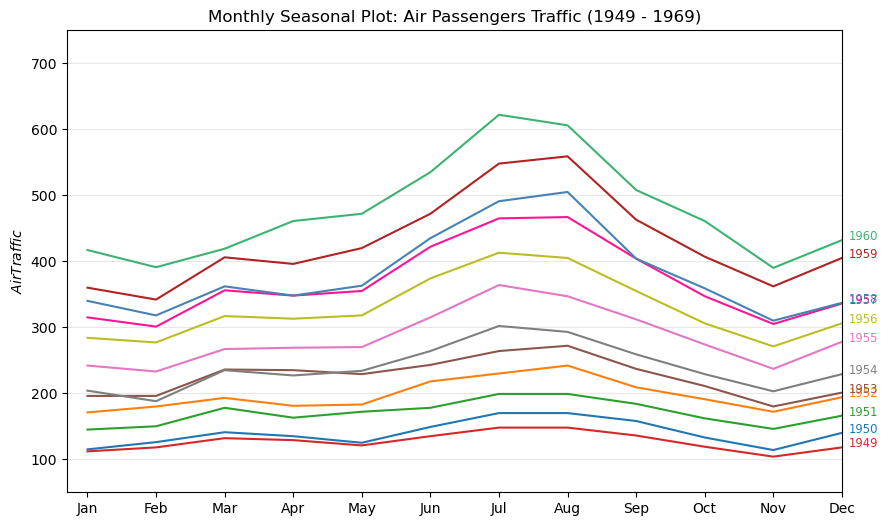

In [6]:
years = passengers["year"].unique()

mycolors = [
    "tab:red",
    "tab:blue",
    "tab:green",
    "tab:orange",
    "tab:brown",
    "tab:grey",
    "tab:pink",
    "tab:olive",
    "deeppink",
    "steelblue",
    "firebrick",
    "mediumseagreen",
]

_, ax = plt.subplots(figsize=(10, 6))

for i, y in enumerate(years):
    pass_year = passengers.filter(pl.col("year") == y)
    ax.plot("month", "value", data=pass_year, color=mycolors[i], label=y)
    ax.text(
        pass_year.shape[0] - 0.9,
        pass_year["value"][-1:].to_numpy()[0],
        y,
        fontsize="small",
        color=mycolors[i],
    )

ax.set(
    xlim=(-0.3, 11),
    ylim=(50, 750),
    ylabel="$Air Traffic$",
    title="Monthly Seasonal Plot: Air Passengers Traffic (1949 - 1969)",
)
ax.grid(axis="y", alpha=0.3)

## Cross Correlation


In [7]:
from statsmodels.tsa import stattools

In [8]:
mortality = pl.read_csv("data/mortality.csv")
mortality.head()

date,mdeaths,fdeaths
str,i64,i64
"""Jan 1974""",2134,901
"""Feb 1974""",1863,689
"""Mar 1974""",1877,827
"""Apr 1974""",1877,677
"""May 1974""",1492,522


[(0.0, 72.0),
 Text(0.5, 1.0, '$Cross\\ Correlation\\ Plot:\\ mdeaths\\ vs\\ fdeaths$')]

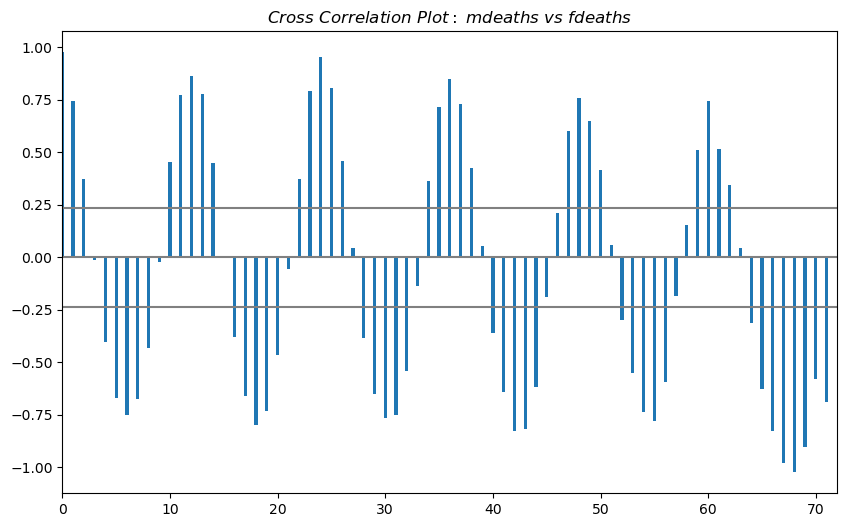

In [9]:
x = mortality["mdeaths"]
y = mortality["fdeaths"]

ccs = stattools.ccf(x, y)[:100]
nlags = len(ccs)

conf_level = 2 / np.sqrt(nlags)

_, ax = plt.subplots(figsize=(10, 6))

ax.hlines(0, xmin=0, xmax=100, color="gray")
ax.hlines(conf_level, xmin=0, xmax=100, color="gray")
ax.hlines(-conf_level, xmin=0, xmax=100, color="gray")

ax.bar(x=np.arange(len(ccs)), height=ccs, width=0.3)
ax.set(xlim=(0, len(ccs)), title=r"$Cross\ Correlation\ Plot:\ mdeaths\ vs\ fdeaths$")

## Decomposition


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
import pandas as pd

passengers = pd.read_csv("data/air_passengers.csv")
passengers.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [12]:
date = passengers["date"]
dates = pd.DatetimeIndex(data=date)

passengers = passengers.set_index(dates)
result = seasonal_decompose(passengers["value"], model="multiplicative")

In [13]:
result = seasonal_decompose(passengers["value"], model="multiplicative")

Text(0.5, 0.98, 'Time Series Decomposition of Air Passengers')

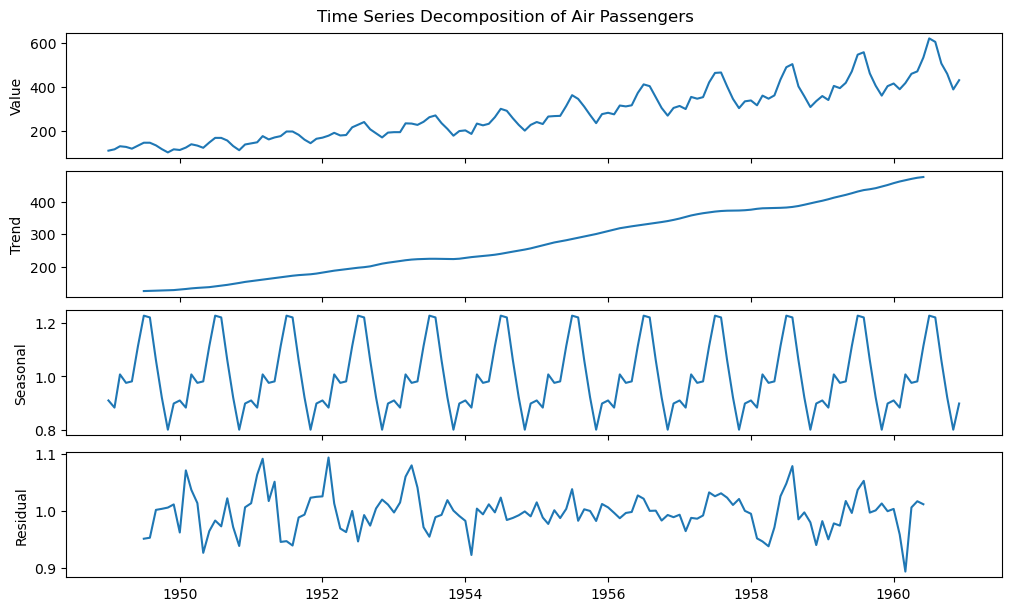

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True, constrained_layout=True)

ys = (result.observed, result.trend, result.seasonal, result.resid)
ylabels = ("Value", "Trend", "Seasonal", "Residual")

for ax, y, ylabel in zip(axes.flatten(), ys, ylabels):
    ax.plot(dates, y)
    ax.set(ylabel=ylabel)

fig.suptitle("Time Series Decomposition of Air Passengers")

## Double Y


In [15]:
economics = pd.read_csv("data/economics.csv", parse_dates=["date"])
economics.head()

,date,pce,pop,psavert,uempmed,unemploy
0,1967-07-01,507.4,198712,12.5,4.5,2944
1,1967-08-01,510.5,198911,12.5,4.7,2945
2,1967-09-01,516.3,199113,11.7,4.6,2958
3,1967-10-01,512.9,199311,12.5,4.9,3143
4,1967-11-01,518.1,199498,12.5,4.7,3066


[Text(0, 0.5, "# Unemployed (1000's)"),
 Text(0.5, 1.0, 'Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis')]

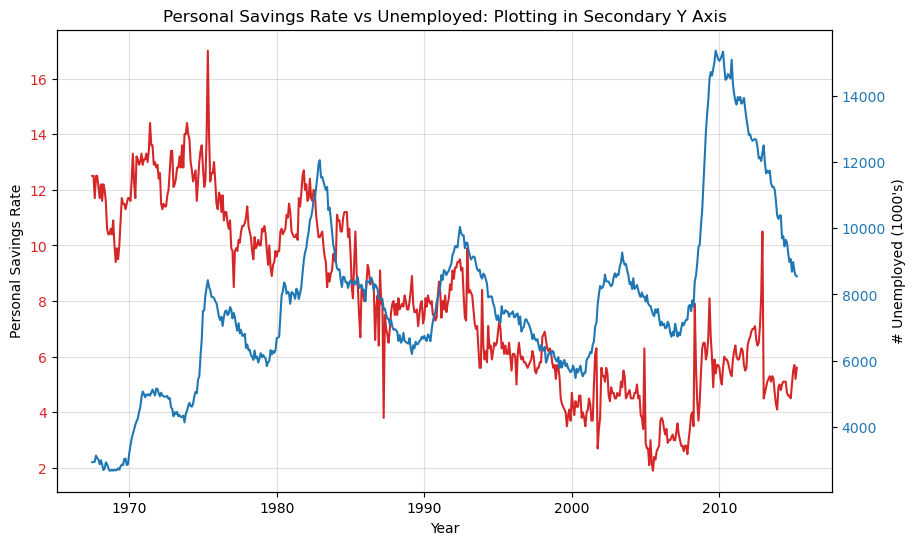

In [16]:
x = economics["date"]
y1 = economics["psavert"]
y2 = economics["unemploy"]

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y1, color="tab:red")

# Plot Line2 (Right Y Axis)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color="tab:blue")

ax.tick_params(axis="x", rotation=0)
ax.set(xlabel="Year", ylabel="Personal Savings Rate")
ax.tick_params(axis="y", rotation=0, labelcolor="tab:red")
ax.grid(alpha=0.4)

ax2.tick_params(axis="y", labelcolor="tab:blue")
ax2.set(
    ylabel="# Unemployed (1000's)",
    title="Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis",
)

## SEM


In [17]:
from scipy.stats import sem

In [18]:
orders = pd.read_csv("data/user_orders_hourofday.csv")
orders.head()

,user_id,order_hour_of_day,quantity
0,1,7,20
1,1,8,23
2,1,9,12
3,1,12,11
4,1,14,10


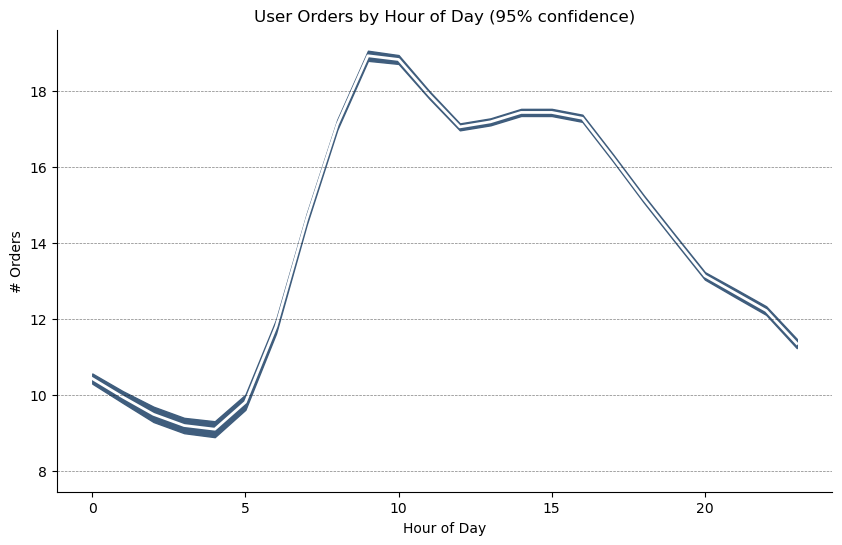

In [19]:
orders_mean = orders.groupby("order_hour_of_day").quantity.mean()
orders_se = orders.groupby("order_hour_of_day").quantity.apply(sem).mul(1.96)

x = orders_mean.index

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(ylabel="# Orders")
ax.plot(x, orders_mean, color="white", lw=2)
ax.fill_between(x, orders_mean - orders_se, orders_mean + orders_se, color="#3F5D7D")

s, e = ax.get_xlim()
ax.set(
    xlim=(s, e),
    xlabel="Hour of Day",
    title="User Orders by Hour of Day (95% confidence)",
)

for y in range(8, 20, 2):
    ax.hlines(y, xmin=s, xmax=e, colors="black", alpha=0.5, linestyles="--", lw=0.5)

ax.spines[["top", "right"]].set_alpha(0)
ax.spines[["bottom", "left"]].set_alpha(1)

In [20]:
from scipy.stats import sem

In [21]:
orders_45d = pd.read_csv(
    "data/orders_45d.csv", parse_dates=["purchase_time", "purchase_date"]
)
orders_45d.head()

,purchase_time,purchase_date,quantity
0,2017-05-16 13:10:30,2017-05-16,5
1,2017-05-16 19:41:10,2017-05-16,3
2,2017-05-19 18:53:40,2017-05-19,2
3,2017-05-18 13:55:47,2017-05-18,1
4,2017-05-14 20:28:25,2017-05-14,3


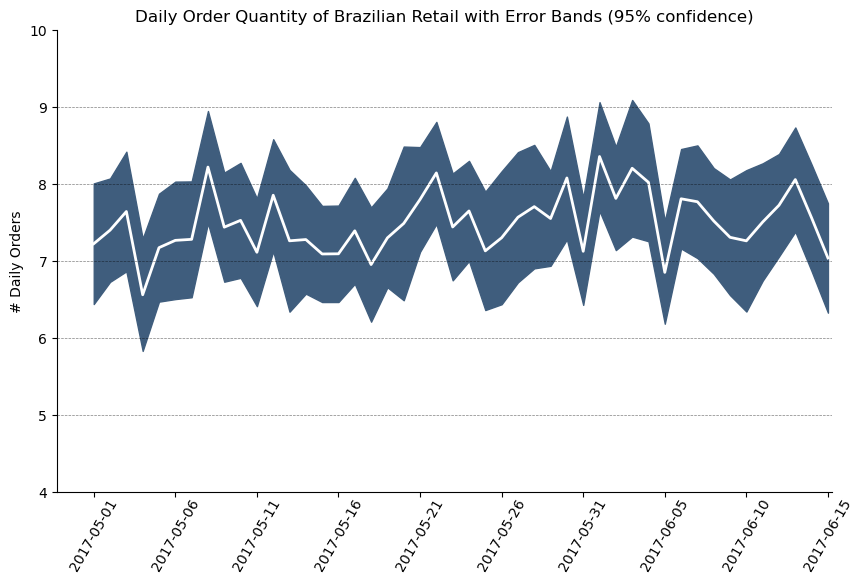

In [22]:
orders_mean = orders_45d.groupby("purchase_date").quantity.mean()
orders_se = orders_45d.groupby("purchase_date").quantity.apply(sem).mul(1.96)

x = [d.date().strftime("%Y-%m-%d") for d in orders_mean.index]

_, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, orders_mean, color="white", lw=2)
ax.fill_between(x, orders_mean - orders_se, orders_mean + orders_se, color="#3F5D7D")

s, e = ax.get_xlim()
ax.set(
    xticks=x[::5],
    xlim=(s, e - 2),
    ylim=(4, 10),
    ylabel="# Daily Orders",
    title="Daily Order Quantity of Brazilian Retail with Error Bands (95% confidence)",
)

for y in range(5, 10):
    ax.hlines(y, xmin=s, xmax=e, colors="black", alpha=0.5, linestyles="--", lw=0.5)

ax.set_xticklabels(
    x[::5],
    rotation=60,
    fontdict={"horizontalalignment": "center", "verticalalignment": "center_baseline"},
)
ax.spines[["top", "right"]].set_alpha(0)
ax.spines[["bottom", "left"]].set_alpha(1)

## Area


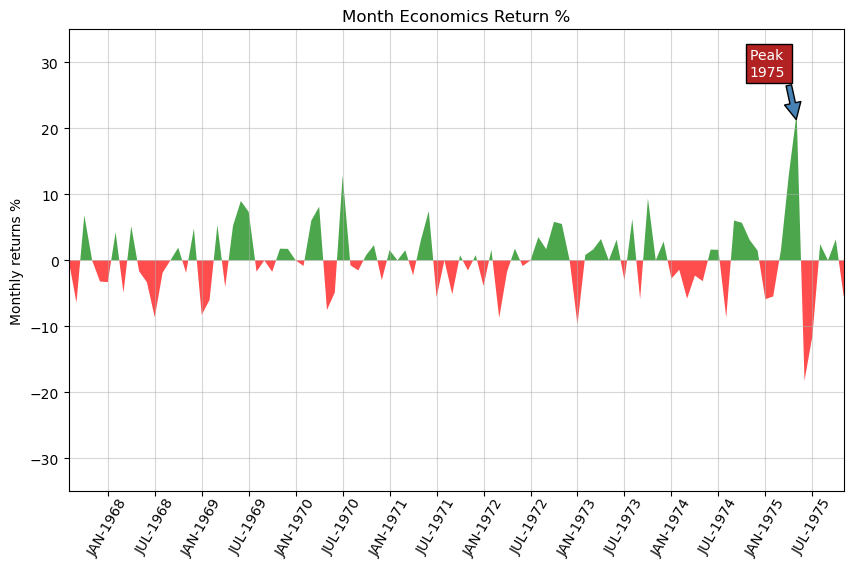

In [23]:
economics = pd.read_csv("data/economics.csv", parse_dates=["date"])

x = np.arange(economics.shape[0])
y_returns = (economics.psavert.diff().fillna(0) / economics.psavert.shift(1)).fillna(
    0
) * 100

_, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(
    x[1:],
    y_returns[1:],
    0,
    where=y_returns[1:] >= 0,
    facecolor="green",
    interpolate=True,
    alpha=0.7,
)

ax.fill_between(
    x[1:],
    y_returns[1:],
    0,
    where=y_returns[1:] <= 0,
    facecolor="red",
    interpolate=True,
    alpha=0.7,
)

ax.annotate(
    "Peak \n1975",
    xy=(94.0, 21.0),
    xytext=(88.0, 28),
    bbox={"boxstyle": "square", "fc": "firebrick"},
    arrowprops={"facecolor": "steelblue", "shrink": 0.05},
    fontsize="medium",
    color="white",
)

ax.set(
    xticks=x[::6],
    xlim=(1, 100),
    ylim=(-35, 35),
    title="Month Economics Return %",
    ylabel="Monthly returns %",
)

xtickvals = [
    f"{str(m)[:3].upper()}-{y!s}"
    for y, m in zip(economics["date"].dt.year, economics["date"].dt.month_name())
]
ax.set_xticklabels(
    xtickvals[::6],
    rotation=60,
    fontdict={"horizontalalignment": "center", "verticalalignment": "center_baseline"},
)
ax.grid(alpha=0.5)

## Stacked Area


In [24]:
visitors = pd.read_csv(
    "data/night_visitors.csv", parse_dates=["yearmon"], date_format="%Y-%m-%d"
)
visitors.head()

,yearmon,Sydney,NSW,Melbourne,VIC,BrisbaneGC,QLD,Capitals,Other
0,Jan 1998,7320,21782,4865,14054,9055,8016,9178,10232
1,Apr 1998,6117,16881,4100,8237,5616,8461,6362,9540
2,Jul 1998,6282,13495,4418,6731,8298,13175,7965,12385
3,Oct 1998,6368,15963,5157,7675,6674,9092,6864,13098
4,Jan 1999,6602,22718,5550,13581,9168,10224,8908,10140


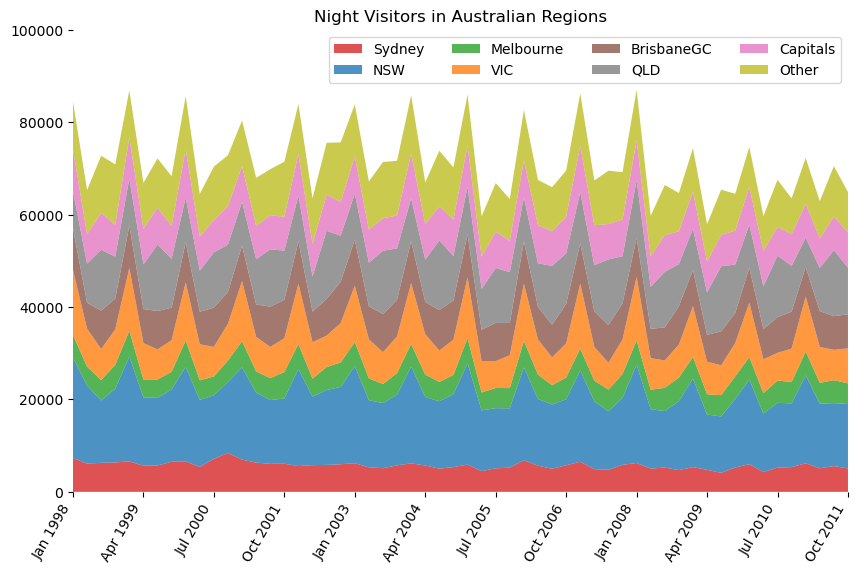

In [25]:
mycolors = [
    "tab:red",
    "tab:blue",
    "tab:green",
    "tab:orange",
    "tab:brown",
    "tab:grey",
    "tab:pink",
    "tab:olive",
]

columns = visitors.columns[1:]
labs = columns.to_numpy().tolist()

x = visitors["yearmon"].to_numpy().tolist()

ys = []

for i in range(8):
    yi = visitors[columns[i]].to_numpy().tolist()
    ys.append(yi)

y = np.vstack(ys)

labs = columns.to_numpy().tolist()

_, ax = plt.subplots(figsize=(10, 6))

ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

ax.set(
    xticks=x[::5],
    xlim=(x[0], x[-1]),
    ylim=[0, 100000],
    title="Night Visitors in Australian Regions",
)
ax.spines[["right", "top", "left", "bottom"]].set_visible(False)
plt.setp(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment="right",
    verticalalignment="top",
)
ax.legend(ncol=4)

## Unstacked Area


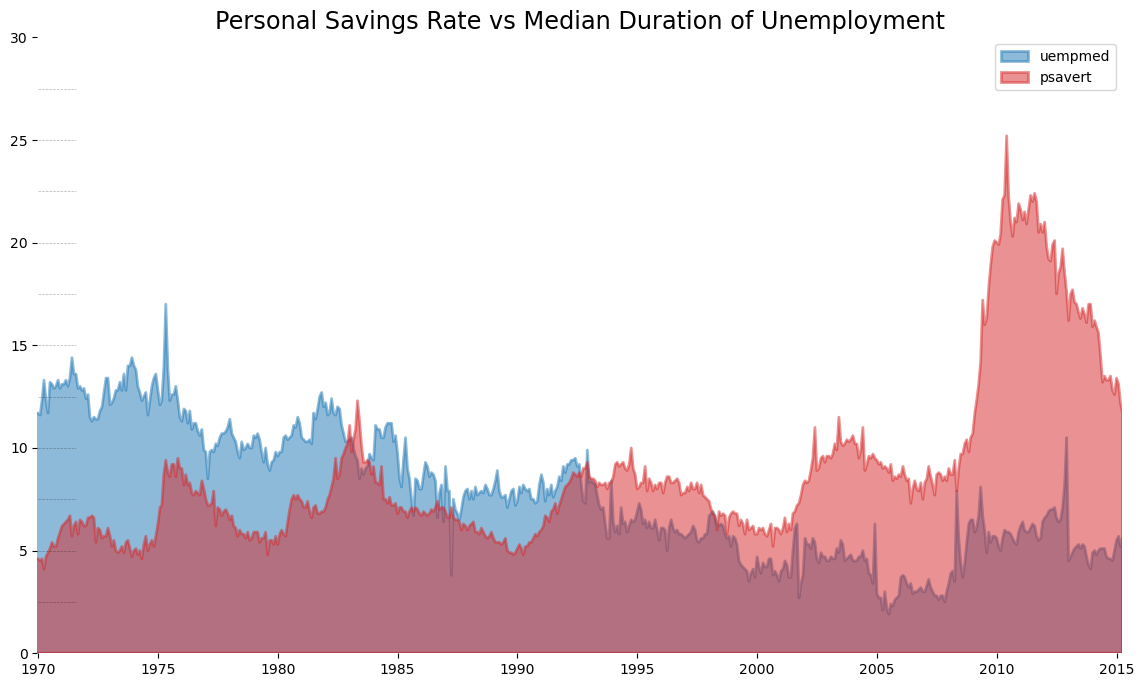

In [26]:
x = economics["date"].array.tolist()
y1 = economics["psavert"].array.tolist()
y2 = economics["uempmed"].array.tolist()
mycolors = [
    "tab:red",
    "tab:blue",
    "tab:green",
    "tab:orange",
    "tab:brown",
    "tab:grey",
    "tab:pink",
    "tab:olive",
]
columns = ["psavert", "uempmed"]

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.fill_between(x, y1=y1, y2=0, label=columns[1], alpha=0.5, color=mycolors[1], lw=2)
ax.fill_between(x, y1=y2, y2=0, label=columns[0], alpha=0.5, color=mycolors[0], lw=2)

ax.set(xlim=(-10, x[-1]), ylim=[0, 30])
ax.set_title(
    "Personal Savings Rate vs Median Duration of Unemployment", fontsize="xx-large"
)
ax.legend(loc="best")
plt.setp(ax.get_xticklabels()[::50], horizontalalignment="center")
plt.setp(ax.get_yticklabels()[::50], horizontalalignment="right")

for y in np.arange(2.5, 30.0, 2.5):
    ax.hlines(
        y, xmin=0, xmax=len(x), colors="black", alpha=0.3, linestyles="--", lw=0.5
    )
ax.spines[["right", "top", "left", "bottom"]].set_visible(False)